In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

<h2 style="color:blue; font-size:40px; text-align:center;">Leemos el Dataframe proporcionado</h2>



## 1. Train.csv



<font size="4"></font>


In [178]:
df = pd.read_csv("train.csv")
df.head()

,id_viaje,id_usuario,id_vehicle,inicio_viaje,final_viaje,lat_ini,long_ini,lat_fin,long_fin,cluster
0,11544264,14999,13184,2022-01-01T00:40:29Z,2022-01-01T01:06:06Z,40.439560,-3.710959,40.531506,-3.636610,73
1,11544318,700120,13230,2022-01-01T00:42:58Z,2022-01-01T01:01:20Z,40.420307,-3.695659,40.442307,-3.704213,8
2,11544295,697271,9893,2022-01-01T00:43:47Z,2022-01-01T01:01:22Z,40.428822,-3.703689,40.408131,-3.706030,40
3,11544349,524536,9998,2022-01-01T00:45:50Z,2022-01-01T01:09:42Z,40.425667,-3.689260,40.414787,-3.701125,7
4,11544356,697386,9789,2022-01-01T00:46:19Z,2022-01-01T01:22:58Z,40.421139,-3.696565,40.421120,-3.696330,8


In [179]:
# Convierte la columna 'inicio_viaje' a un formato de fecha y hora
df['date2'] = pd.to_datetime(df['inicio_viaje'])

# Extrae la fecha, hora, día de la semana y mes de la columna 'date2'
df['date'] = df['date2'].dt.date
df['hour'] = pd.DatetimeIndex(df['date2']).hour
df['dia_semana'] = df['date2'].dt.dayofweek
df['mes'] = df['date2'].dt.month

# Define una función para determinar la estación del año basada en el mes
def get_season(mes):
    if 3 <= mes <= 5:
        return '1'  # Primavera
    elif 6 <= mes <= 8:
        return '2'  # Verano
    elif 9 <= mes <= 11:
        return '3'  # Otoño
    else:
        return '4'  # Invierno

# Aplicamos la función 'get_season' para crear una nueva columna 'season'
df['season'] = df['mes'].apply(get_season)

# Muestra las primeras filas del DataFrame con las columnas agregadas
df.head()


,id_viaje,id_usuario,id_vehicle,inicio_viaje,final_viaje,lat_ini,long_ini,lat_fin,long_fin,cluster,date2,date,hour,dia_semana,mes,season
0,11544264,14999,13184,2022-01-01T00:40:29Z,2022-01-01T01:06:06Z,40.439560,-3.710959,40.531506,-3.636610,73,2022-01-01 00:40:29+00:00,2022-01-01,0,5,1,4
1,11544318,700120,13230,2022-01-01T00:42:58Z,2022-01-01T01:01:20Z,40.420307,-3.695659,40.442307,-3.704213,8,2022-01-01 00:42:58+00:00,2022-01-01,0,5,1,4
2,11544295,697271,9893,2022-01-01T00:43:47Z,2022-01-01T01:01:22Z,40.428822,-3.703689,40.408131,-3.706030,40,2022-01-01 00:43:47+00:00,2022-01-01,0,5,1,4
3,11544349,524536,9998,2022-01-01T00:45:50Z,2022-01-01T01:09:42Z,40.425667,-3.689260,40.414787,-3.701125,7,2022-01-01 00:45:50+00:00,2022-01-01,0,5,1,4
4,11544356,697386,9789,2022-01-01T00:46:19Z,2022-01-01T01:22:58Z,40.421139,-3.696565,40.421120,-3.696330,8,2022-01-01 00:46:19+00:00,2022-01-01,0,5,1,4


In [180]:
# Se Agrupa el dataframe por diferentes columnas y cuenta el número de viajes para cadacombinacion unica de las variables

num_viajes=df.groupby(['cluster', 'hour','dia_semana','mes','season','date'])['cluster'].count().to_frame(name = 'trips').reset_index()
num_viajes.head()

,cluster,hour,dia_semana,mes,season,date,trips
0,1,0,0,2,4,2022-02-14,1
1,1,0,0,2,4,2022-02-21,1
2,1,0,0,3,1,2022-03-28,1
3,1,0,0,4,1,2022-04-25,2
4,1,0,0,5,1,2022-05-02,1


In [181]:
# Convierte las columnas específicas a tipos de datos de cadena (str)
num_viajes['cluster'] = num_viajes['cluster'].astype(str)
num_viajes['hour'] = num_viajes['hour'].astype(str)
num_viajes['dia_semana'] = num_viajes['dia_semana'].astype(str)
num_viajes['season'] = num_viajes['season'].astype(str)
num_viajes['date'] = num_viajes['date'].astype(str)
num_viajes['mes'] = num_viajes['mes'].astype(str)



In [182]:
num_viajes.dtypes

cluster       object
hour          object
dia_semana    object
mes           object
season        object
date          object
trips          int64
dtype: object


<h2 style="color:blue; font-size:40px; text-align:center;">Generar Datos para "Test"</h2>

## Leer Dataset sample_submission.csv para hacer la predicciones del modelo


In [183]:
test = pd.read_csv("sample_submission_original.csv")
print(test)

                      Id     trips
0       72_2022-09-30_22  2.869596
1       93_2022-09-30_22  2.869596
2       36_2022-09-30_22  2.869596
3       83_2022-09-30_22  2.869596
4       92_2022-09-30_22  2.869596
...                  ...       ...
131833  45_2023-01-01_00  2.869596
131834  59_2023-01-01_00  2.869596
131835  25_2023-01-01_00  2.869596
131836  37_2023-01-01_00  2.869596
131837  85_2023-01-01_00  2.869596

[131838 rows x 2 columns]


In [184]:
# Dividir la columna 'Id' en varias columnas usando el carácter '_' como separador.
# Se crean nuevas columnas para cada componente resultante de la división.
split_test= test["Id"].str.split("_", n = 3, expand = True)
print(split_test)

         0           1   2
0       72  2022-09-30  22
1       93  2022-09-30  22
2       36  2022-09-30  22
3       83  2022-09-30  22
4       92  2022-09-30  22
...     ..         ...  ..
131833  45  2023-01-01  00
131834  59  2023-01-01  00
131835  25  2023-01-01  00
131836  37  2023-01-01  00
131837  85  2023-01-01  00

[131838 rows x 3 columns]


In [185]:
# Asigna las columnas resultantes de la división al DataFrame 'test'
test['cluster'] = split_test[0]
test['date'] = split_test[1]
test['hour'] = split_test[2]

# Convierte la columna 'date' a formato de fecha y hora
test['date'] = pd.to_datetime(test['date'])

# Extrae el día de la semana, el mes y la estación del año a partir de la columna 'date'
test['dia_semana'] = test['date'].dt.dayofweek
test['mes'] = test['date'].dt.month
test['season'] = test['mes'].apply(get_season)

# Elimina la columna 'trips' si existe
test = test.drop(columns=['trips'])


In [186]:
# Convierte las columnas específicas a tipos de datos de cadena (str)
test['date']=test['date'].astype(str)
test['dia_semana']=test['dia_semana'].astype(str)
test['mes']=test['mes'].astype(str)

print(test)


                      Id cluster        date hour dia_semana mes season
0       72_2022-09-30_22      72  2022-09-30   22          4   9      3
1       93_2022-09-30_22      93  2022-09-30   22          4   9      3
2       36_2022-09-30_22      36  2022-09-30   22          4   9      3
3       83_2022-09-30_22      83  2022-09-30   22          4   9      3
4       92_2022-09-30_22      92  2022-09-30   22          4   9      3
...                  ...     ...         ...  ...        ...  ..    ...
131833  45_2023-01-01_00      45  2023-01-01   00          6   1      4
131834  59_2023-01-01_00      59  2023-01-01   00          6   1      4
131835  25_2023-01-01_00      25  2023-01-01   00          6   1      4
131836  37_2023-01-01_00      37  2023-01-01   00          6   1      4
131837  85_2023-01-01_00      85  2023-01-01   00          6   1      4

[131838 rows x 7 columns]


# Càlculo de media por Cluster  

In [187]:
media_por_cluster['hour'] = media_por_cluster['hour'].astype(object)

In [188]:
# Calcula la media del número de viajes por cluster y por hora
media_por_cluster = num_viajes.groupby(['cluster', 'hour'])['trips'].mean().to_frame(name='trips').reset_index()

print(media_por_cluster)

     cluster hour     trips
0          1    0  2.010695
1          1    1  1.710280
2          1   10  1.703704
3          1   11  1.856383
4          1   12  2.160194
...      ...  ...       ...
2395      99    5  1.041667
2396      99    6  1.076087
2397      99    7  1.676136
2398      99    8  3.120419
2399      99    9  3.297170

[2400 rows x 3 columns]


In [189]:
# Fusiona los DataFrames 'test' y 'media_por_cluster' por las columnas 'cluster' y 'hour'
test_media = pd.merge(test, media_por_cluster, how='left', left_on=['cluster', 'hour'], right_on=['cluster', 'hour'])

# Llena los valores nulos en la columna 'trips' con ceros
test_media['trips'] = test_media['trips'].fillna(0)


In [190]:
# Convertir la columna 'hour' a tipo entero (int)
test_media['hour'] = test_media['hour'].astype(int)

# Imprimir el DataFrame después de la conversión
print(test_media)

                      Id cluster        date  hour dia_semana mes season  \
0       72_2022-09-30_22      72  2022-09-30    22          4   9      3   
1       93_2022-09-30_22      93  2022-09-30    22          4   9      3   
2       36_2022-09-30_22      36  2022-09-30    22          4   9      3   
3       83_2022-09-30_22      83  2022-09-30    22          4   9      3   
4       92_2022-09-30_22      92  2022-09-30    22          4   9      3   
...                  ...     ...         ...   ...        ...  ..    ...   
131833  45_2023-01-01_00      45  2023-01-01     0          6   1      4   
131834  59_2023-01-01_00      59  2023-01-01     0          6   1      4   
131835  25_2023-01-01_00      25  2023-01-01     0          6   1      4   
131836  37_2023-01-01_00      37  2023-01-01     0          6   1      4   
131837  85_2023-01-01_00      85  2023-01-01     0          6   1      4   

           trips  
0       2.731092  
1       1.994382  
2       2.489270  
3       1.5

In [191]:
# Convertir la columna 'hour' a tipo entero (int)
num_viajes['hour'] = num_viajes['hour'].astype(int)

# Imprimir el DataFrame después de la conversión
print(num_viajes)

       cluster  hour dia_semana mes season        date  trips
0            1     0          0   2      4  2022-02-14      1
1            1     0          0   2      4  2022-02-21      1
2            1     0          0   3      1  2022-03-28      1
3            1     0          0   4      1  2022-04-25      2
4            1     0          0   5      1  2022-05-02      1
...        ...   ...        ...  ..    ...         ...    ...
405819     100    23          6   8      2  2022-08-07      1
405820     100    23          6   8      2  2022-08-14      1
405821     100    23          6   9      3  2022-09-04      1
405822     100    23          6   9      3  2022-09-11      2
405823     100    23          6   9      3  2022-09-18      1

[405824 rows x 7 columns]



<h2 style="color:blue; font-size:40px; text-align:center;">Utilizamos un Dataset de Clima para completar datos</h2>

## 1. export_weather.csv

Hay que meterlo en num_viajes (entrenamiento) y en test (predicciones reales)

In [192]:
weather = pd.read_csv('export_weather.csv')

In [193]:
# Crear una lista de horas de 0 a 23
horas = list(range(24))

# Repetir cada fila en df2 por cada hora y asignar la hora correspondiente
weather_expandido = pd.DataFrame()
for _, fila in weather.iterrows():
    fila_repetida = pd.DataFrame([fila] * 24)
    fila_repetida['hour'] = horas
    weather_expandido = pd.concat([weather_expandido, fila_repetida], ignore_index=True)
weather_expandido

,date,tavg,tmin,tmax,prcp,wdir,wspd,pres,hour
0,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,0
1,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,1
2,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,2
3,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,3
4,2022-01-01,-0.794859,-0.940391,-0.580302,-0.341636,-1.19286,-1.129823,1.649661,4
...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,19
8756,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,20
8757,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,21
8758,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,22


In [194]:
# Crear una nueva fila con la fecha del 1 de enero de 2022 y los datos del 31 de diciembre de 2022
new_row = weather_expandido.iloc[-1].copy()
new_row['date'] = '2023-01-01'
new_row_df = pd.DataFrame([new_row])

# Añadir la nueva fila al DataFrame
weather_expandido = pd.concat([weather_expandido, new_row_df],ignore_index = True)
weather_expandido['hour'].iloc[8760] = 0

# Mostrar las últimas filas del DataFrame actualizado para verificar la adición
weather_expandido.tail()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9460\445015735.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_expandido['hour'].iloc[8760] = 0


,date,tavg,tmin,tmax,prcp,wdir,wspd,pres,hour
8756,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,20
8757,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,21
8758,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,22
8759,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,23
8760,2023-01-01,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,0


In [195]:
# Acceder a la columna 'date' del DataFrame weather_expandido
weather_expandido['date']

0       2022-01-01
1       2022-01-01
2       2022-01-01
3       2022-01-01
4       2022-01-01
           ...    
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
8760    2023-01-01
Name: date, Length: 8761, dtype: object

In [196]:
# Filtrar filas en weather_expandido para obtener datos hasta el 30 de septiembre de 2022 (inclusive)
weather_train = weather_expandido[weather_expandido['date'] <= '2022-09-30']

# Filtrar filas en weather_expandido para obtener datos desde el 30 de septiembre de 2022 en adelante
weather_test = weather_expandido[weather_expandido['date'] >= '2022-09-30']


In [197]:
weather_test

,date,tavg,tmin,tmax,prcp,wdir,wspd,pres,hour
6528,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,0
6529,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,1
6530,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,2
6531,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,3
6532,2022-09-30,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580,4
...,...,...,...,...,...,...,...,...,...
8756,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,20
8757,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,21
8758,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,22
8759,2022-12-31,-1.117715,-1.056661,-0.968687,-0.341636,-0.397940,-1.526017,1.395076,23


<h2 style="color:blue; font-size:40px; text-align:center;">Merge de Datasets </h2>


## 1. Merge con train (num_viajes) 
## 2. weather_train 
## 3. test (para predicciones reales) con weather_test

In [198]:
# Realizar un merge entre los DataFrames num_viajes y weather_train utilizando las columnas 'date' y 'hour'
num_viajes_weather = pd.merge(num_viajes,weather_train, on = ['date','hour'])
# Ordenar el DataFrame resultante por 'date' y 'hour'
num_viajes_weather.sort_values(['date','hour'])

,cluster,hour,dia_semana,mes,season,date,trips,tavg,tmin,tmax,prcp,wdir,wspd,pres
363863,3,0,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
363864,5,0,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
363865,7,0,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
363866,8,0,5,1,4,2022-01-01,2,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
363867,10,0,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287390,95,21,4,9,3,2022-09-30,1,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
287391,97,21,4,9,3,2022-09-30,5,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
287392,98,21,4,9,3,2022-09-30,9,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
287393,99,21,4,9,3,2022-09-30,4,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580


In [199]:
# Convertir la columna 'hour' a tipo entero (int) en el DataFrame test
test['hour'] = test['hour'].astype(int)

In [200]:
# Realizar un merge entre los DataFrames test y weather_test utilizando las columnas 'date' y 'hour'
test = pd.merge(test, weather_test, on=['date', 'hour'], suffixes=('_test', '_weather'))

# Ordenar el DataFrame resultante por 'date' y 'hour'
test.sort_values(['date', 'hour'], inplace=True)

<h2 style="color:blue; font-size:40px; text-align:center;"> Split para metrica </h2>

In [201]:
# Crear un conjunto de características (features) seleccionando columnas específicas del DataFrame num_viajes_weather
num_viajes_features = num_viajes_weather[['cluster', 'hour', 'dia_semana', 'mes', 'tmin', 'pres']]
print(num_viajes_features)
# Crear un conjunto de etiquetas (labels) que contiene la variable objetivo 'trips' del DataFrame num_viajes_weather
num_viajes_labels = num_viajes_weather['trips']

       cluster  hour dia_semana mes      tmin      pres
0            1     0          0   2 -0.998526  0.217618
1            4     0          0   2 -0.998526  0.217618
2            8     0          0   2 -0.998526  0.217618
3           13     0          0   2 -0.998526  0.217618
4           25     0          0   2 -0.998526  0.217618
...        ...   ...        ...  ..       ...       ...
405819      94     4          0   1 -1.681610  2.413418
405820      95     4          0   1 -1.681610  2.413418
405821      95     3          1   5  0.251374  0.249441
405822      98     3          1   5  0.251374  0.249441
405823      95     4          0   1 -1.158397  1.681485

[405824 rows x 6 columns]


In [202]:
from sklearn.model_selection import train_test_split
# Dividir los datos en conjuntos de entrenamiento y prueba
train_features, test_features, train_labels, test_labels = train_test_split(num_viajes_features, num_viajes_labels, test_size = 0.25, random_state = 42)

In [203]:
test_features.sort_values(['hour'])

,cluster,hour,dia_semana,mes,tmin,pres
363972,86,0,5,4,-0.998526,-2.471441
3676,21,0,3,4,-0.315441,0.249441
322620,35,0,3,5,0.992593,-0.307464
7818,85,0,5,5,0.803655,-0.291553
362852,64,0,1,3,-0.940391,-0.116525
...,...,...,...,...,...,...
308191,46,23,0,5,0.193239,0.185795
386264,90,23,5,1,-1.405470,2.477064
385892,59,23,2,4,-0.867722,-0.848458
316461,62,23,4,1,-1.216531,2.206567



<h2 style="color:blue; font-size:40px; text-align:center;"> Entrenamiento con slipt realizado </h2>

In [204]:
# Crear un modelo de Gradient Boosting Regressor con parámetros específicos
model = GradientBoostingRegressor(loss="absolute_error", n_estimators=100, learning_rate=0.2, max_depth=5,random_state=42)

# Entrenar el modelo utilizando las características de entrenamiento (train_features) y las etiquetas de entrenamiento (train_labels)
model.fit(train_features, train_labels)


# Definir los hiperparámetros a probar
parametros = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

#from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'n_estimators': [50, 100, 150],
#    'learning_rate': [0.05, 0.1, 0.2],
#    'max_depth': [5, 10, 15]
#}



In [205]:
# Configurar GridSearchCV
#busqueda_grid = GridSearchCV(model, parametros, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Ejecutar la búsqueda
#busqueda_grid.fit(train_features, train_labels)

# Mejores parámetros
#print("Mejores parámetros:", busqueda_grid.best_params_)

In [206]:
# Hacer predicciones en el conjunto de características de prueba (test_features)
y_pred = model.predict(test_features)

<h2 style="color:blue; font-size:40px; text-align:center;"> Metrica con split realizado </h2>

In [207]:
test_features

,cluster,hour,dia_semana,mes,tmin,pres
284419,80,21,4,1,-1.216531,2.206567
385861,94,23,2,2,-0.780520,0.933640
160315,77,15,3,2,-1.201998,1.506457
214353,13,18,1,9,-0.228239,-0.323376
306587,35,22,6,5,0.571115,-1.755419
...,...,...,...,...,...,...
401047,46,2,4,2,-0.925857,0.090326
141551,69,14,3,5,0.701919,-0.100614
62580,72,9,3,2,-1.071194,0.774524
402133,87,5,3,2,-0.780520,0.392646


In [208]:
# Calculate the absolute errors
errors = abs(y_pred - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', (np.mean(errors)))

Mean Absolute Error: 1.277623474539798


<h2 style="color:blue; font-size:40px; text-align:center;"> Prediccion real </h2>

In [209]:
# Ordenar el DataFrame num_viajes_weather por la columna 'date' en orden ascendente
num_viajes_weather.sort_values('date')

,cluster,hour,dia_semana,mes,season,date,trips,tavg,tmin,tmax,prcp,wdir,wspd,pres
13899,24,1,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
381279,3,18,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
337165,98,10,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
337164,82,10,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
337163,81,10,5,1,4,2022-01-01,1,-0.794859,-0.940391,-0.580302,-0.341636,-1.192860,-1.129823,1.649661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184901,58,16,4,9,3,2022-09-30,6,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
184902,59,16,4,9,3,2022-09-30,2,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
184903,60,16,4,9,3,2022-09-30,8,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580
184877,32,16,4,9,3,2022-09-30,3,-0.285740,-0.388110,-0.245859,-0.315915,2.005748,-0.126131,-0.466580


In [210]:
num_viajes_weather.columns

Index(['cluster', 'hour', 'dia_semana', 'mes', 'season', 'date', 'trips',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres'],
      dtype='object')

In [211]:
# Importar el Regresor Gradient Boosting de scikit-learn
from sklearn.ensemble import GradientBoostingRegressor

# Datos de entrenamiento
X = num_viajes_weather.loc[:, ['cluster', 'hour', 'dia_semana', 'mes', 'tavg', 'tmin', 'tmax', 'pres']]  # Características
y = num_viajes_weather.loc[:, 'trips']  # Variable objetivo

# Datos de prueba
Z = test.loc[:, ['cluster', 'hour', 'dia_semana', 'mes', 'tavg', 'tmin', 'tmax', 'pres']]

# Crear un modelo de Gradient Boosting Regressor con parámetros específicos
model = GradientBoostingRegressor(loss="absolute_error", n_estimators=100, learning_rate=0.1, max_depth=10)

# Entrenar el modelo utilizando los datos de entrenamiento
model.fit(X, y)

# Realizar predicciones en el conjunto de prueba
pred = pd.Series(model.predict(Z), index=Z.index)





In [156]:
test['prediction']= pred
test['prediction'] = test['prediction'].fillna(0)
test.tail()

,Id,cluster,date,hour,dia_semana,mes,season,tavg,tmin,tmax,prcp,wdir,wspd,pres,prediction
131833,45_2023-01-01_00,45,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.560103
131834,59_2023-01-01_00,59,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.611755
131835,25_2023-01-01_00,25,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.925954
131836,37_2023-01-01_00,37,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.455389
131837,85_2023-01-01_00,85,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.668223


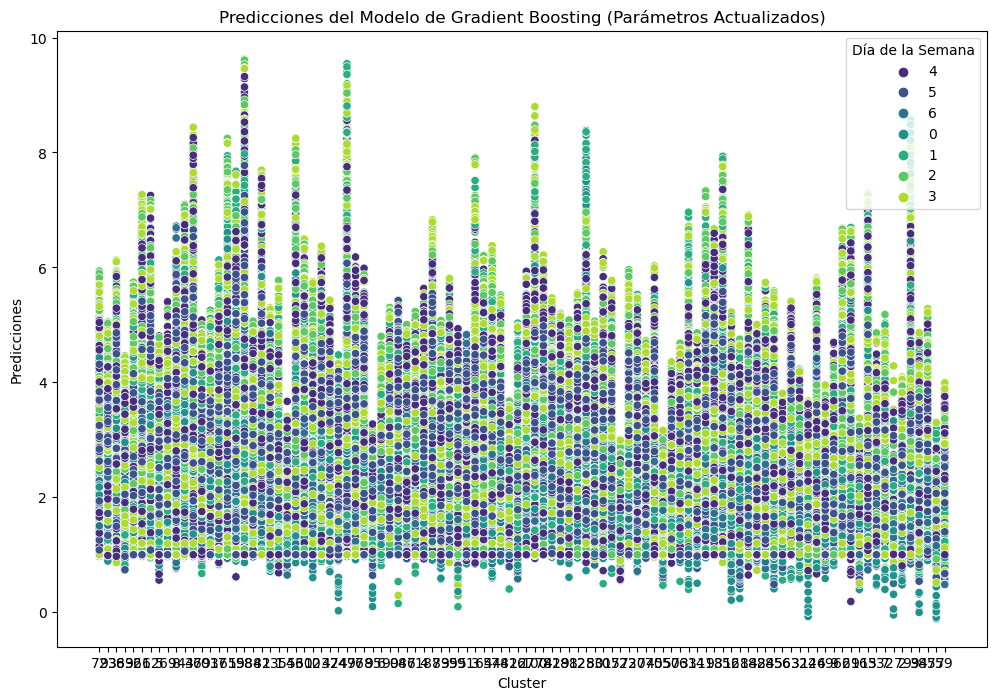

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear un DataFrame con las predicciones y los datos de prueba
df_resultado = pd.DataFrame({'Predicciones': pred, 'Cluster': Z['cluster'], 'Dia': Z['dia_semana']})

# Graficar la relación entre las predicciones y las variables de interés
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Cluster', y='Predicciones', hue='Dia', data=df_resultado, palette='viridis')
plt.title('Predicciones del Modelo de Gradient Boosting (Parámetros Actualizados)')
plt.xlabel('Cluster')
plt.ylabel('Predicciones')
plt.legend(title='Día de la Semana')
plt.show()

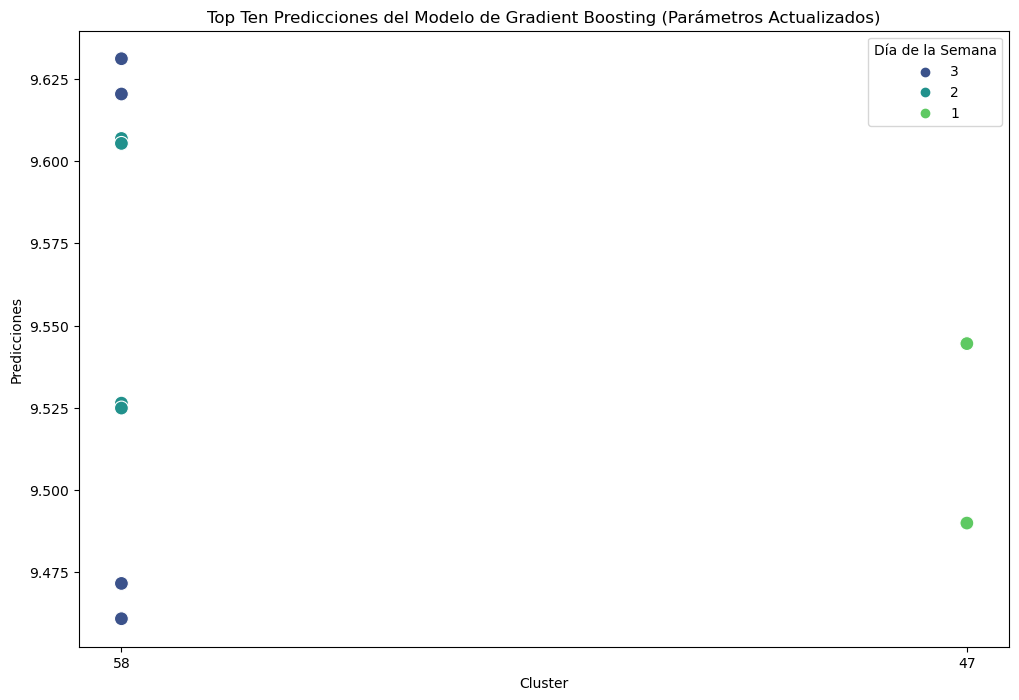

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear un DataFrame con las predicciones y los datos de prueba
df_resultado = pd.DataFrame({'Predicciones': pred, 'Cluster': Z['cluster'], 'Dia': Z['dia_semana']})

# Seleccionar las diez observaciones con las mayores predicciones
top_ten = df_resultado.nlargest(10, 'Predicciones')

# Graficar la relación entre las predicciones y las variables de interés para el top ten
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Cluster', y='Predicciones', hue='Dia', data=top_ten, palette='viridis', s=100)  # Ajustar el tamaño de los puntos (s) según sea necesario
plt.title('Top Ten Predicciones del Modelo de Gradient Boosting (Parámetros Actualizados)')
plt.xlabel('Cluster')
plt.ylabel('Predicciones')
plt.legend(title='Día de la Semana')
plt.show()


PREPARACIÓN DE LA ENTREGA

In [159]:
test.tail()

,Id,cluster,date,hour,dia_semana,mes,season,tavg,tmin,tmax,prcp,wdir,wspd,pres,prediction
131833,45_2023-01-01_00,45,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.560103
131834,59_2023-01-01_00,59,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.611755
131835,25_2023-01-01_00,25,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.925954
131836,37_2023-01-01_00,37,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.455389
131837,85_2023-01-01_00,85,2023-01-01,0,6,1,4,-1.117715,-1.056661,-0.968687,-0.341636,-0.39794,-1.526017,1.395076,1.668223


In [160]:
test.rename(columns={'prediction': 'trips'}, inplace=True)
test = pd.DataFrame(data=test, columns=["Id", "trips"])
test

,Id,trips
0,72_2022-09-30_22,3.398093
1,93_2022-09-30_22,2.103837
2,36_2022-09-30_22,3.057953
3,83_2022-09-30_22,1.600304
4,92_2022-09-30_22,2.581445
...,...,...
131833,45_2023-01-01_00,1.560103
131834,59_2023-01-01_00,1.611755
131835,25_2023-01-01_00,1.925954
131836,37_2023-01-01_00,1.455389


In [161]:
test.dtypes

Id        object
trips    float64
dtype: object

In [162]:
test.to_csv('entrega_mpz_20_01.csv',index=False)

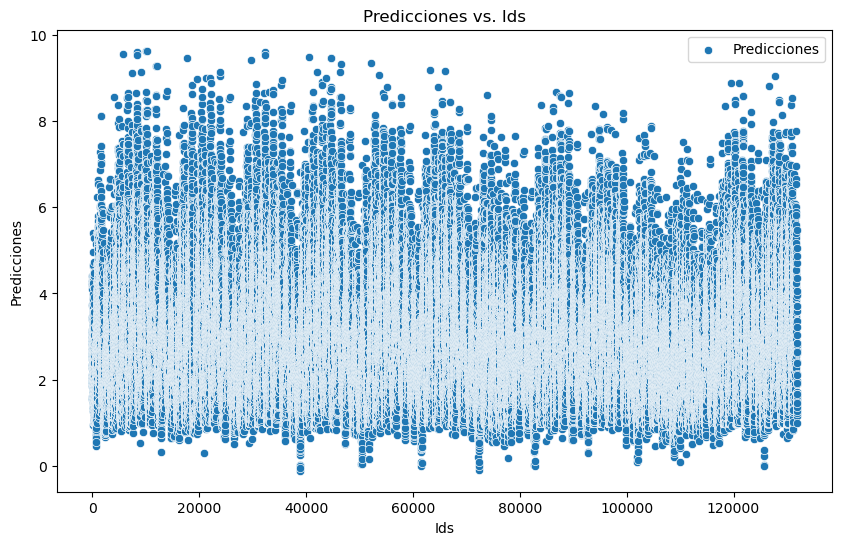

In [163]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test.index, y=test['trips'], label='Predicciones')
plt.title('Predicciones vs. Ids')
plt.xlabel('Ids')
plt.ylabel('Predicciones')
plt.legend()
plt.show()